In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [8]:
df = pd.read_csv("results_full.csv")

metric = "CRPS"
df = df[df["metric"] == metric]
df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'LogisticRegression' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF', 'TabPFNRegressor', 'GPBoost_CRPS'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN',
    'GPBoost_CRPS': 'GP'

}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

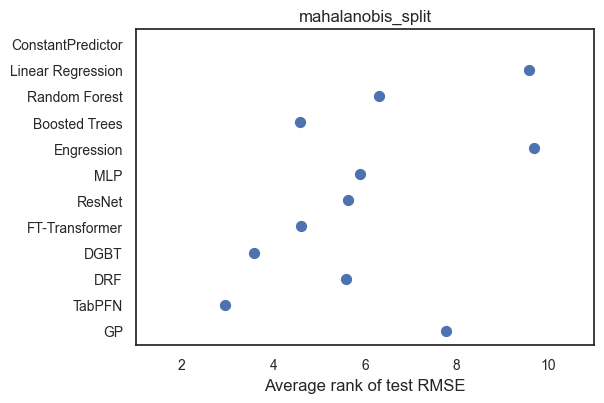

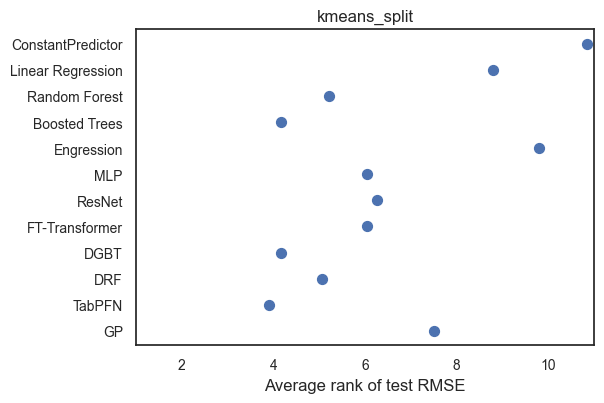

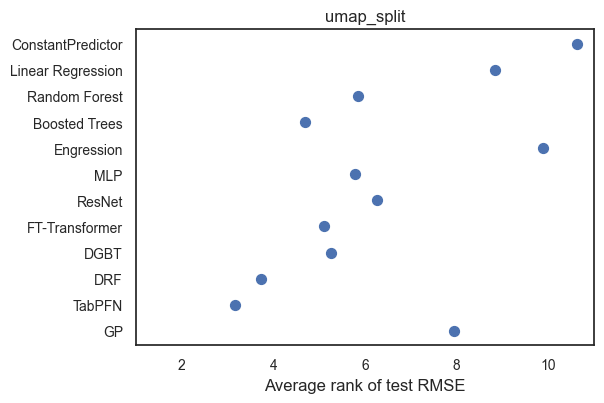

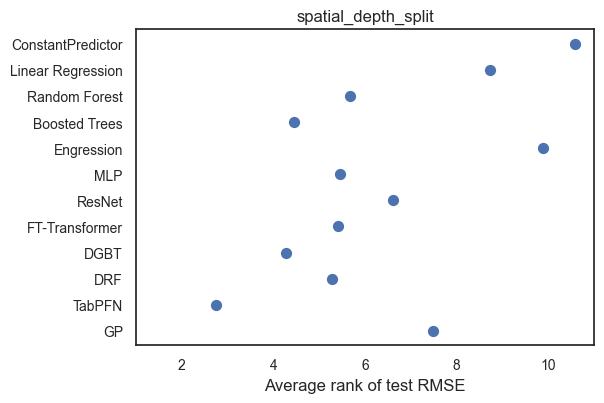

In [9]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

display_order = []
for m in method_order:
    name = rename_map.get(m, m)
    if name not in display_order:
        display_order.append(name)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    ranks = table.rank(ascending=True)  
    summary = pd.DataFrame({
        "Mean":   ranks.mean(axis=1),
        "Median": ranks.median(axis=1),
        "Std":    ranks.std(axis=1),
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = (
        summary["Method"]
        .astype(str)
        .map(rename_map)
        .fillna(summary["Method"].astype(str))
    )

    plot_df = (summary
            .set_index("Method")
            .reindex(display_order)
            .dropna(subset=["Mean"])
            .reset_index())

    # Horizontal dot plot (like your overall)
    ypos = np.arange(len(plot_df))
    fig, ax = plt.subplots()
    ax.scatter(plot_df["Mean"].values, ypos, s=50)
    ax.set_yticks(ypos)
    ax.set_yticklabels(plot_df["Method"])
    ax.invert_yaxis()        # best at top
    ax.set_xlim(1, 11)      # normalized accuracy in %
    ax.set_xlabel("Average rank of test RMSE")
    ax.set_ylabel("")
    ax.grid(False)
    ax.set_title(str(split)) # label the split
    plt.tight_layout()

    # save (PDF keeps text/vector crisp for LaTeX; change to .png if you prefer)
    safe_split = str(split).replace(" ", "_").replace("/", "-")
    fname = f"{split}_rankings_335_{metric}.pdf"
    plt.savefig(os.path.join(outdir, fname), bbox_inches="tight")
    plt.show()
    plt.close()

In [4]:
df = df[df["metric"] == "CRPS"]

df = df[df["split_method"] != "random_split"]

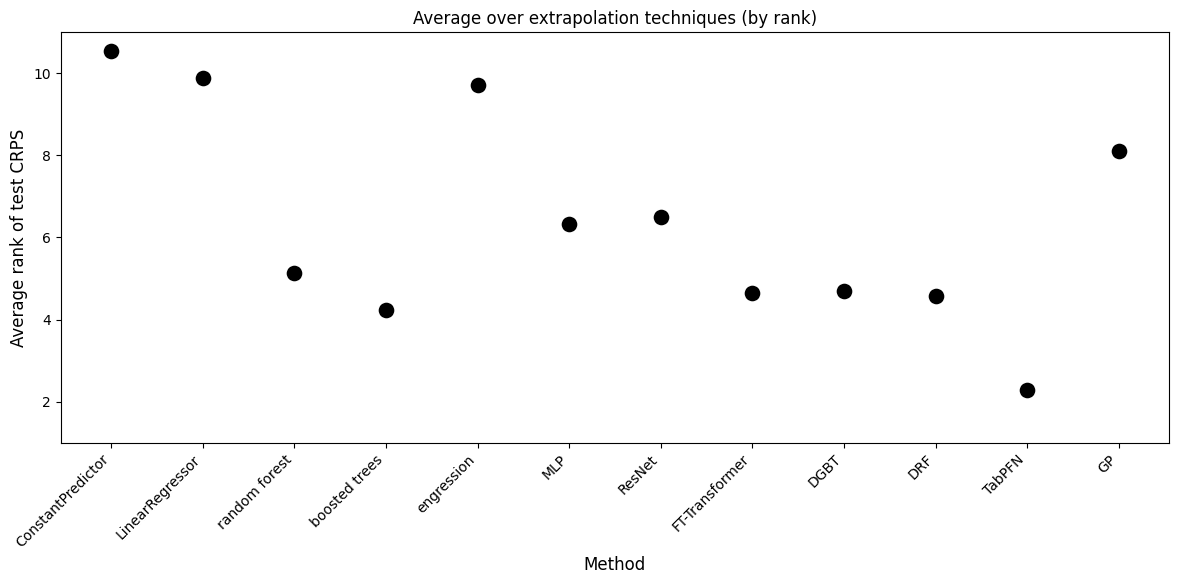

In [5]:
df["rank"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .rank(ascending=True)
)


overall = (
    df
    .groupby('model')['rank']
    .mean()
    .reset_index(name='Mean')
)


method_order = [
    'ConstantPredictor', 'LinearRegressor',
    'RandomForestClassifier', 'RandomForestRegressor',
    'LGBMClassifier', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF', 'TabPFNRegressor', 'GPBoost_CRPS'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

# 3) Map to display names
rename_map = {
    'RandomForestClassifier':'random forest',
    'RandomForestRegressor':'random forest',
    'LGBMClassifier':       'boosted trees',
    'LGBMRegressor':        'boosted trees',
    'Engression':           'engression',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'DGBT':                 'DGBT',
    'DRF':                  'DRF',
    'TabPFNRegressor':     'TabPFN',
    'GPBoost_CRPS':         'GP'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])



plt.figure(figsize=(12,6))
sns.scatterplot(data=overall, x='Method', y='Mean', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average rank of test CRPS')
plt.xlabel('Method')
plt.title('Average over extrapolation techniques (by rank)')
plt.ylim(1, 11)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/average_rank_CRPS.png', bbox_inches='tight')
plt.show()


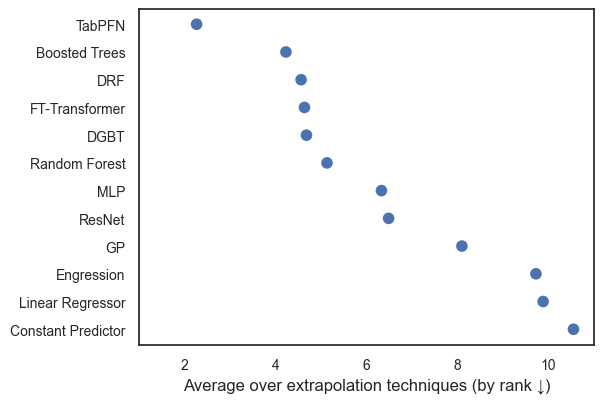

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns, os

sns.set_theme(style="white", rc={"axes.grid": False})
plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

# df: columns ['split_method','task_id','model','value'] where 'value' = CRPS
df = df.copy()
df = df[pd.to_numeric(df["value"], errors="coerce").notna()]

# Rank per split/task (lower = better)
df["rank"] = df.groupby(["split_method","task_id"])["value"].rank(ascending=True)

# Canonical display names (collapse variants)
rename_map = {
    "RandomForestClassifier":"Random Forest",
    "RandomForestRegressor":"Random Forest",
    "LGBMClassifier":"Boosted Trees",
    "LGBMRegressor":"Boosted Trees",
    "Engression":"Engression",
    "MLP":"MLP",
    "ResNet":"ResNet",
    "FTTransformer":"FT-Transformer",
    "DGBT":"DGBT",        
    "DRF":"DRF",          
    "LightGBMLSS":"DGBT", 
    "drf":"DRF",          
    "TabPFNRegressor":"TabPFN",
    "GPBoost_CRPS":"GP",
    "LinearRegressor":"Linear Regressor",
    "ConstantPredictor":"Constant Predictor",
}
df["Method"] = df["model"].map(rename_map).fillna(df["model"])

# Aggregate AFTER renaming
stats = (df.groupby("Method")["rank"]
           .mean()
           .dropna()
           .sort_values(ascending=True))

# Horizontal dot plot
ypos = np.arange(len(stats))
fig, ax = plt.subplots()
ax.scatter(stats.values, ypos, s=70, edgecolors="none")
ax.set_yticks(ypos)
ax.set_yticklabels(stats.index)
ax.invert_yaxis()
ax.set_xlabel("Average over extrapolation techniques (by rank ↓)")
ax.set_ylabel("")
# dynamic x-limits
ax.set_xlim(1.0, float(np.ceil(stats.values.max()+0.3)))
plt.tight_layout()

os.makedirs("PICTURES", exist_ok=True)
plt.savefig("PICTURES/average_rank_CRPS.pdf", bbox_inches="tight")  # vector
plt.show(); plt.close()
